In [1]:
import tensorcircuit as tc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial

### Solving QUBO problems using QAOA

Here we show how to solve a quadratic unconstrained binary optimization (QUBO) problem using QAOA.  Later on below we will extend this to show how to solve binary Markowitz portfolio optimization problems.

Consider minimizing the following 2x2 QUBO objective function:

$\begin{pmatrix}x_1 & x_2\end{pmatrix}\begin{pmatrix}-5& -2 \\-2 & 6\end{pmatrix}\begin{pmatrix}x_1\\x_2\end{pmatrix} = -5x_1^2 -4x_1x_2 +6x_2^2$

Clearly this is minimized at $(x_1,x_2) = (1,0)$, with corresponding objective function value of $-5$

We first convert this to an Ising Hamiltonian by mapping $x_i\rightarrow \frac{I-Z_i}{2}$

This gives

$$-\frac{5}{4}(I-Z_1)^2 -\frac{4}{4}(I-Z_1)(I-Z_2) + \frac{6}{4}(I-Z_2)^2 $$

which simplifies to

$$-\frac{1}{2}I +\frac{7}{2}Z_1   -2Z_2 -Z_1Z_2$$ 

The $-I/2$ term is simply a constant offset, so we can solve the problem by finding the minimum of 
$$\langle \psi | \frac{7}{2}Z_1 -2Z_2 -Z_1Z_2 |\psi\rangle$$ 
Note that the minimum should correspond to the computational basis state $|10\rangle$, and the corresponding true objective function value should be $-4.5$ (ignoring the offset value of $-1/2$)

In [2]:
# we first manually encode the terms (-7/2) Z_1 - 2 Z_2 - Z_1Z_2 as:
pauli_terms = [
    [1, 0],
    [0, 1],
    [1, 1],
]  # see the TensorCircuit whitepaper for 'pauli structures'
weights = [7 / 2, -2, -1]

# see below for a function to generate the pauli terms and weights from the QUBO matrix

In [3]:
# Now we define the QAOA ansatz of depth nlayers
def QAOA_from_Ising(params, nlayers, pauli_terms, weights):
    nqubits = len(pauli_terms[0])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.h(i)
    for j in range(nlayers):
        for k in range(len(pauli_terms)):
            term = pauli_terms[k]
            index_of_ones = []
            for l in range(len(term)):
                if term[l] == 1:
                    index_of_ones.append(l)
            if len(index_of_ones) == 1:
                c.rz(index_of_ones[0], theta=2 * weights[k] * params[2 * j])
            elif len(index_of_ones) == 2:
                c.exp1(
                    index_of_ones[0],
                    index_of_ones[1],
                    unitary=tc.gates._zz_matrix,
                    theta=weights[k] * params[2 * j],
                )
            else:
                raise ValueError("Invalid number of Z terms")

        for i in range(nqubits):
            c.rx(i, theta=params[2 * j + 1])  # mixing terms
    return c

For a general state that is the output of a quantum circuit c, we first define the corresponding loss with respect to the Ising Hamiltonian.

In [4]:
def Ising_loss(c, pauli_terms, weights):
    loss = 0.0
    for k in range(len(pauli_terms)):
        term = pauli_terms[k]
        index_of_ones = []

        for l in range(len(term)):
            if term[l] == 1:
                index_of_ones.append(l)

        if len(index_of_ones) == 1:
            delta_loss = weights[k] * c.expectation_ps(z=[index_of_ones[0]])

        else:
            delta_loss = weights[k] * c.expectation_ps(
                z=[index_of_ones[0], index_of_ones[1]]
            )

        loss += delta_loss

    return K.real(loss)

For the particular case of a circuit corresponding to a QAOA ansatz this is:

In [5]:
def QAOA_loss(nlayers, pauli_terms, weights, params):
    c = QAOA_from_Ising(params, nlayers, pauli_terms, weights)
    return Ising_loss(c, pauli_terms, weights)

In [6]:
K = tc.set_backend("tensorflow")

In [7]:
def QAOA_solve(pauli_terms, weights, nlayers, iterations):
    print_every = 100
    learning_rate = 1e-2

    loss_val_grad = K.value_and_grad(partial(QAOA_loss, nlayers, pauli_terms, weights))
    loss_val_grad_jit = K.jit(loss_val_grad)

    opt = K.optimizer(tf.keras.optimizers.Adam(learning_rate))

    params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)
    print(f"initial params: {params}")
    for i in range(iterations):
        loss, grads = loss_val_grad_jit(params)
        if i % print_every == 0:
            print(K.numpy(loss))
        params = opt.update(grads, params)

    return params

In [12]:
iterations = 500
nlayers = 2
final_params = QAOA_solve(pauli_terms, weights, nlayers, iterations)

initial params: [ 0.39931756 -0.49578992 -0.22545011 -0.40585193]
-2.1728685
-4.177884
-4.2291102
-4.2291365
-4.229136


We note that for nlayers=2 and 500 iterations, the objective function does not in this case (although it depends on the initial parameters)converge to the true value of $-4.5$.  However, the we see below that the final wavefunction does have large overlap with the desired state $|10\rangle$, so measuring the output of the QAOA algorithm will, with high probability, output the correct answer.

In [13]:
def print_output(c):
    n = c._nqubits
    N = 2**n
    x_label = r"$\left|{0:0" + str(n) + r"b}\right>$"
    labels = [x_label.format(i) for i in range(N)]
    plt.bar(range(N), c.probability())
    plt.xticks(range(N), labels, rotation=70);

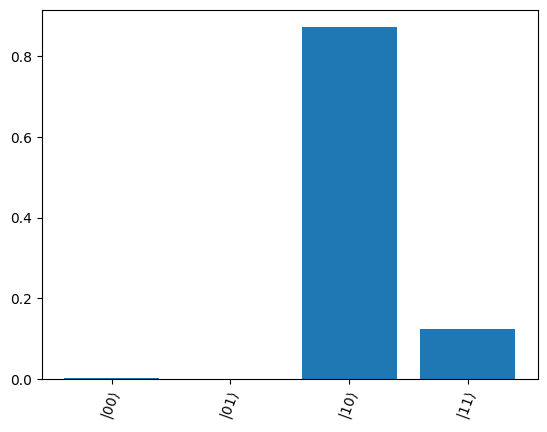

In [14]:
c = QAOA_from_Ising(final_params, nlayers, pauli_terms, weights)

print_output(c)

### General Case
For the general QUBO case, we wish to minimize
$$ x^T Q x$$
where $x\in\{0,1\}^n$ and $Q\in\mathbb{R}^{n\times n}$ is a real symmetric matrix.

This maps to an Ising Hamiltonian 
$$\frac{1}{2}\left(\sum_{i=1}^n C_{ii} + \sum_{i<j}C_{ij}\right) I - \frac{1}{2}\sum_{i=1}^n \left(\sum_{j=1}^n C_{ij} \right)Z_i +\frac{1}{2}\sum_{i<j}C_{ij}Z_iZ_j$$

Below is a simple function which can perform this mapping:

In [15]:
def QUBO_to_Ising(Q):
    # input is nxn symmetric numpy array corresponding to QUBO matrix Q

    n = Q.shape[0]

    offset = np.triu(Q, 0).sum() / 2
    pauli_terms = []
    weights = []

    weights = -np.sum(Q, axis=1) / 2

    for i in range(n):
        term = np.zeros(n)
        term[i] = 1
        pauli_terms.append(term)

    for i in range(n - 1):
        for j in range(i + 1, n):
            term = np.zeros(n)
            term[i] = 1
            term[j] = 1
            pauli_terms.append(term)

            weight = Q[i][j] / 2
            weights = np.concatenate((weights, weight), axis=None)

    return pauli_terms, weights, offset

### Solving portfolio optimization problems with QAOA

In a simple boolean Markowitz portfolio optimization problem, we wish to solve 

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^T x$$
subject to 
$$ 1^T x = B$$
where 
* $n$: number of assets under consideration
* $q > 0 $: risk-appetite
* $\Sigma \in \mathbb{R}^{n\times n}$: covariance matrix of the assets
* $\mu\in\mathbb{R}^n$: mean return of the assets
* $B$: budget (i.e., total number of assets out of $n$ that can be selected)

Our first step is to convert this constrained quadratic programming problem into a QUBO.  We do this by adding a penalty factor $t$ and consider the alternative problem:

$$ \min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^Tx  + t(1^Tx-B)^2$$

The variables in the linear terms $\mu^Tx = \mu_1 x_1 + \mu_2 x_2+\ldots$ can all be squared (since they are boolean variables), i.e. we can consider

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \sum_{i=1}^n\mu_i x_i^2  + t(1^Tx-B)^2$$
which is a QUBO defined by the matrix $Q$ 

$$ Q = q\Sigma -\mu\begin{pmatrix}1 & \\ & 1\\ & & \ddots\end{pmatrix} + t\begin{pmatrix}1 -2B & 1 & \ldots & 1 \\
1 & 1-2B & 1 & \ldots \\1 & 1 & 1-2B \\
\vdots\end{pmatrix}$$
i.e., we wish to mimimize
$$ x^T Q X + tB$$
and we ignore the constant term $t B$.
We can now solve this by QAOA as above.

Let us first define a function to convert portfolio data into a QUBO matrix:

In [16]:
def QUBO_from_portfolio(cov, mean, q, B, t):
    # cov: n x n covariance numpy array
    # mean: numpy array of means
    n = cov.shape[0]
    R = np.diag(mean)
    S = np.ones((n, n)) - 2 * B * np.diag(np.ones(n))

    Q = q * cov - R + t * S
    return Q

We can test this using the qiskit_finance package to generate some stock covariance and mean data:

In [17]:
import datetime
from qiskit_finance.data_providers import RandomDataProvider

In [18]:
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

Using this mean and covariance data, we can now define our portfolio optimization problem, convert it to a QUBO matrix, and then extract the pauli terms and weights

In [19]:
q = 0.5
budget = 3  # Note that in this example, there are 4 assets, but a budget of only 3
penalty = 3

Q = QUBO_from_portfolio(sigma, mu, q, budget, penalty)
portfolio_pauli_terms, portfolio_weights, portfolio_offset = QUBO_to_Ising(Q)

In [20]:
# Brute force search over classical results for comparison before we run QAOA
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                x = np.array([i, j, k, l])
                print(f"{i}{j}{k}{l}: {np.dot(x,np.dot(Q,x))- portfolio_offset}")

0000: 21.006979417669037
0001: 6.006208358124514
0010: 6.006857249462996
0011: -2.994037697463167
0100: 6.007889613170697
0101: -2.992836964752989
0110: -2.992179512275861
0111: -5.9930299775811875
1000: 5.992965725313347
1001: -3.007905195444355
1010: -3.0070278423618397
1011: -6.008022650501182
1100: -3.0060506769683
1101: -6.006877116105166
1110: -6.005991201884008
1111: -3.006941528402507


We see that, due to the penalty, the lowest energy solutions correspond to 0111, 1011, 1101, 1110, i.e. the portfolios with only 3 assets.

In [21]:
iterations = 1000
nlayers = 3
final_params = QAOA_solve(portfolio_pauli_terms, portfolio_weights, nlayers, iterations)

initial params: [ 0.13778198 -0.75357753 -0.01271329 -0.5461785  -0.1501883   0.36323363]
-4.204754
-5.681799
-5.6837077
-5.6837044
-5.6837053
-5.683704
-5.6837063
-5.683709
-5.6837063
-5.683705


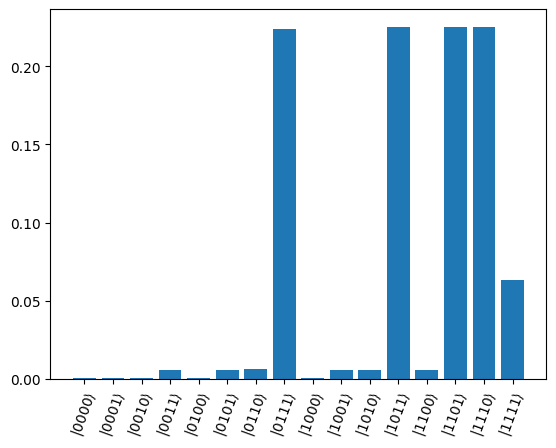

In [22]:
c_final = QAOA_from_Ising(
    final_params, nlayers, portfolio_pauli_terms, portfolio_weights
)
print_output(c_final)